Imports and data loading.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns

data = pd.read_csv('pokemon.csv')

Adding new column 'generation'

In [13]:
data['generation'] = ''
data.loc[data.national_number <= 151, 'generation'] = 1
data.loc[(data.national_number >= 152) & (data.national_number <= 251), 'generation'] = 2
data.loc[(data.national_number >= 252) & (data.national_number <= 386), 'generation'] = 3
data.loc[(data.national_number >= 387) & (data.national_number <= 493), 'generation'] = 4
data.loc[(data.national_number >= 494) & (data.national_number <= 649), 'generation'] = 5
data.loc[(data.national_number >= 650) & (data.national_number <= 721), 'generation'] = 6
data.loc[(data.national_number >= 722) & (data.national_number <= 809), 'generation'] = 7
data.loc[(data.national_number >= 810) & (data.national_number <= 890), 'generation'] = 8

Removing Partner pokemons and setting Mega, Alolan and Galarian forms to gen 6, 7 and 8 respectively.
It also ignores pokemons with no base_stats. Full name includes pokemon species name.

In [15]:
prefix = []
data['ignore'] = False

for i, row in data.iterrows():
    fn_split = row['full_name'].split()
    if len(fn_split) != 1:
        if fn_split[0] == 'Partner':
            data.at[i,'ignore'] = True
        elif fn_split[0] == 'Mega':
            data.at[i,'generation'] = 6
        elif fn_split[0] == 'Alolan':
            data.at[i,'generation'] = 7
        elif fn_split[0] == 'Galarian':
            data.at[i,'generation'] = 8
        else:
            prefix.append(fn_split[0])
            
    if row['base_stats']=='{}':
        data.at[i,'ignore'] = True
    
    if row['name'] not in row['full_name']:
        data.at[i,'full_name'] = row['full_name'] + ' ' +row['name']
    

It removes ignored and duplicated pokemons, drops temp column 'ignore'

In [16]:
data = data[~data.ignore]
data.drop(['ignore'],axis=1,inplace=True)
data = data[~data.duplicated(subset=data.columns[2:])]

Function to expand dict value 'base_stats' into new columns. 'att' key changed to column 'atk' for better comprehension.

In [4]:
def add_base_stats(row): 
    stats_dict = json.loads(row['base_stats'].replace("'",'"'))
    for k in stats_dict:
        col_name = k if k != 'att' else 'atk'
        row[col_name] = pd.to_numeric(stats_dict[k])
    return row

data = data.apply(add_base_stats, axis=1)

For each attribute, it plots a histogram distribution, fits a kernel distribution estimate (KDE) line and save the figures.

In [10]:
att_list = ['hp', 'atk', 'def', 'sp.atk', 'sp.def', 'speed']
for att in att_list:
    ax = sns.distplot(data[att], kde=True)
    ax.set_title('{} Distribution'.format(att.capitalize()))
    ax.set(xlabel=att.upper(), ylabel='%')
    plt.savefig(f'img/hist/{att}.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

It plots pairwise bivariate distribution of attributes. In the diagonal line it's plotted the default univariate histogram.

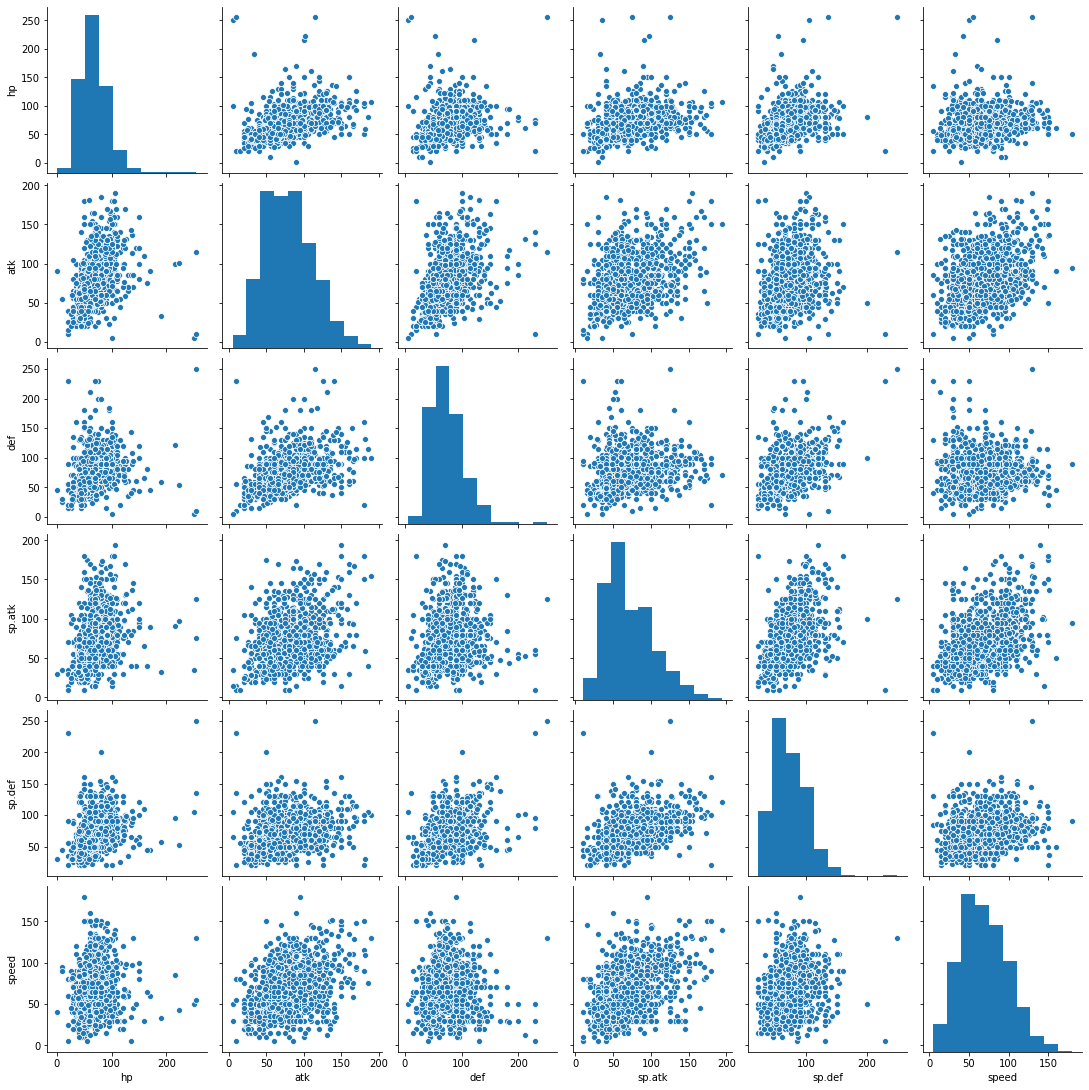

In [21]:
sns.pairplot(data[att_list])
plt.savefig('img/hist/pair_plot.png')

Using PairGrid object to plot pairwise bivariate distribution of attributes with KDE of 6 levels. In the diagonal line it's plotted the default univariate KDE.

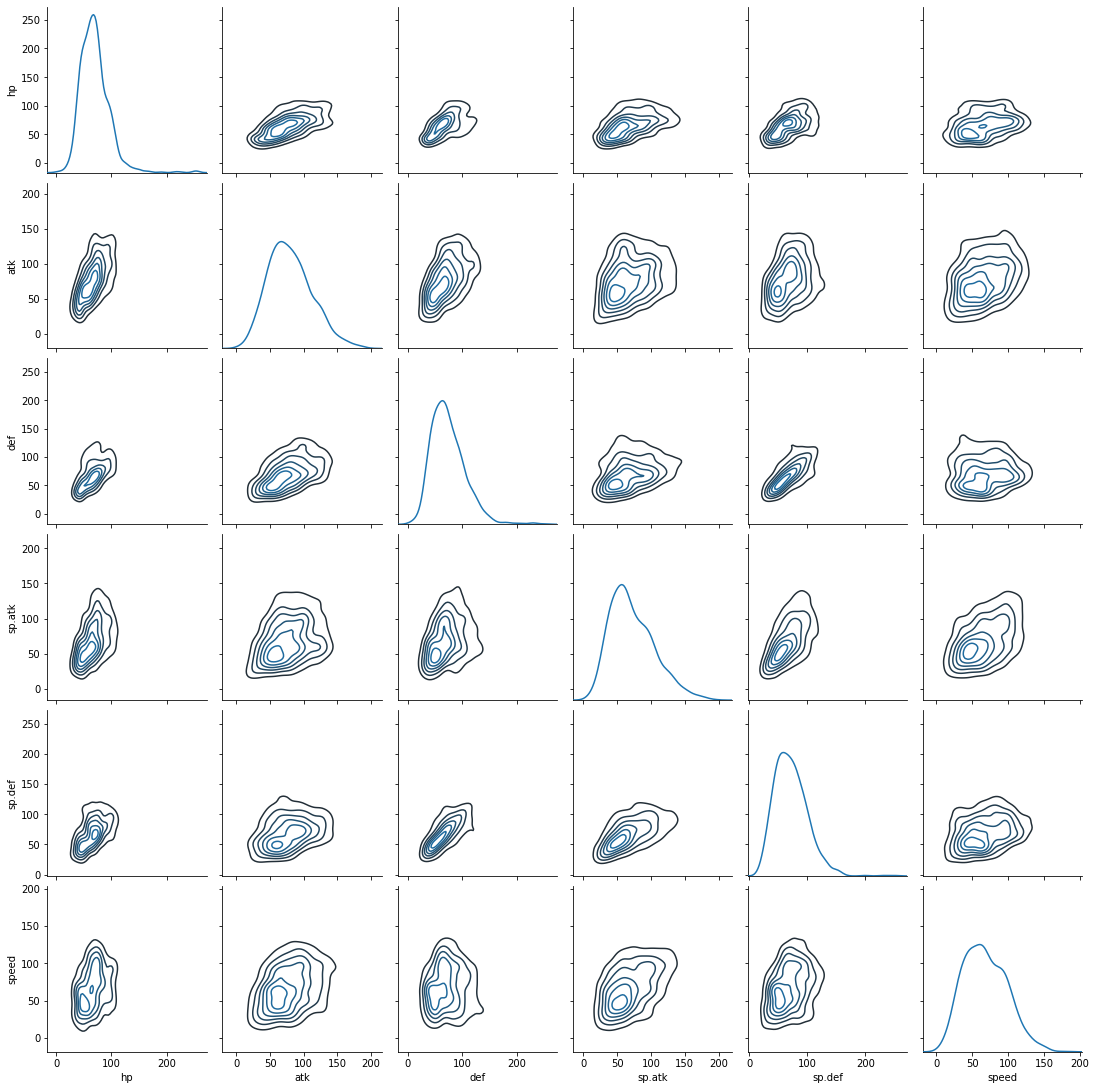

In [22]:
g = sns.PairGrid(data[att_list])
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6)
plt.savefig('img/hist/pair_grid.png')